# US Agriculture Analysis
In this Jupyter notebook, I walk through my process for analyzing 2017 census data on U.S. agriculture, with a particular emphasis on the cattle industry.

The data for this analysis can be accessed on [USDA's website](https://www.nass.usda.gov/Publications/AgCensus/2017/index.php). 

![USDA-logo.png](media/USDA-Logo.png)

Retrieving the data in a format that is conducive to the type of ad hoc analysis that I'd like to perform turned out to be a bit challenging. USDA's website provides a nice "query tool" that allows users to perform basic filtering of data, but data export options are a bit limited. In the end the best option was to download the full dataset as a very large (over 1GB) tab-deliminated text file.

Working with large data files in-memory can be challenging so I decided to upload the dataset into a postgres database using [bit.io](https://bit.io/). 

![USDA-logo.png](media/bit-io-icon.png)

This allows me to query the data using SQL and load the necessary portions of the data into dataframes, as opposed loading the full, 1.6 GB file into a dataframe right from the start.

### Pulling the data
Below we can run a few queries against the bit.io hosted Postgres table to give us a sense of the data.

In [ ]:


df_1 = _deepnote_execute_sql("""-- previewing the first few rows of the data
SELECT * 
FROM "paytondhubbard/census_data"."2017_agg_census_data"
LIMIT 5
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
df_1

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,15,HI,HAWAII,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",1
1,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,16,ID,IDAHO,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",37
2,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,17,IL,ILLINOIS,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",55
3,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,18,IN,INDIANA,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",24
4,1,72,191,5,ECONOMICS,"FUELS, INCL LUBRICANTS - OPERATIONS WITH EXPENSE",FUELS,STATE,19,IA,IOWA,None,None,"FARM SALES: (100,000 TO 249,999 $) AND EXPENSE...",38


The first table within the dataset has helpful, high-level statistics on farming on a state by state level. We'll filter the total dataset down to only the first table of census chapter 1 and save that table to `table_1_df_raw`

In [1]:


table_1_df_raw = _deepnote_execute_sql("""SELECT *
FROM "paytondhubbard/census_data"."2017_agg_census_data"
WHERE census_chapter = 1
AND census_table = 1
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
table_1_df_raw

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,1,1,2,1,ECONOMICS,FARM OPERATIONS - ACRES OPERATED,FARM OPERATIONS,STATE,48,TX,TEXAS,None,None,None,"127,036,184"
1,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,NATIONAL,99,US,US TOTAL,None,None,None,"2,042,220"
2,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,1,AL,ALABAMA,None,None,None,"40,592"
3,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,2,AK,ALASKA,None,None,None,990
4,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,4,AZ,ARIZONA,None,None,None,"19,086"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,1,1,3,1,ECONOMICS,"FARM OPERATIONS - AREA OPERATED, MEASURED IN A...",FARM OPERATIONS,STATE,34,NJ,NEW JERSEY,None,None,None,74
5504,1,1,3,1,ECONOMICS,"FARM OPERATIONS - AREA OPERATED, MEASURED IN A...",FARM OPERATIONS,STATE,35,NM,NEW MEXICO,None,None,None,"1,624"
5505,1,1,3,1,ECONOMICS,"FARM OPERATIONS - AREA OPERATED, MEASURED IN A...",FARM OPERATIONS,STATE,36,NY,NEW YORK,None,None,None,205
5506,1,1,3,1,ECONOMICS,"FARM OPERATIONS - AREA OPERATED, MEASURED IN A...",FARM OPERATIONS,STATE,37,NC,NORTH CAROLINA,None,None,None,182


Tables 46 and 47 contain information on the gender of the farmers themselves that we will save into `farmer_gender_table_df_raw`.

In [80]:


farmer_gender_table_df_raw = _deepnote_execute_sql("""SELECT *
FROM "paytondhubbard/census_data"."2017_agg_census_data"
WHERE census_chapter = 2
AND census_table IN (46, 47)
AND agg_level_desc = 'STATE'
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
farmer_gender_table_df_raw

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,2,47,1,3,DEMOGRAPHICS,"PRODUCERS, FEMALE - ACRES OPERATED",PRODUCERS,STATE,15,HI,HAWAII,None,None,None,"347,305"
1,2,46,1,1,DEMOGRAPHICS,"PRODUCERS, MALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,39,OH,OHIO,None,None,None,"72,398"
2,2,47,1,3,DEMOGRAPHICS,"PRODUCERS, FEMALE - ACRES OPERATED",PRODUCERS,STATE,10,DE,DELAWARE,None,None,None,"187,769"
3,2,47,1,3,DEMOGRAPHICS,"PRODUCERS, FEMALE - ACRES OPERATED",PRODUCERS,STATE,12,FL,FLORIDA,None,None,None,"3,615,319"
4,2,46,1,1,DEMOGRAPHICS,"PRODUCERS, MALE - NUMBER OF OPERATIONS",PRODUCERS,STATE,40,OK,OKLAHOMA,None,None,None,"72,234"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2,47,1,2,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF PRODUCERS",PRODUCERS,STATE,6,CA,CALIFORNIA,None,None,None,"46,235"
596,2,47,1,2,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF PRODUCERS",PRODUCERS,STATE,8,CO,COLORADO,None,None,None,"28,839"
597,2,47,1,2,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF PRODUCERS",PRODUCERS,STATE,9,CT,CONNECTICUT,None,None,None,"3,892"
598,2,47,1,2,DEMOGRAPHICS,"PRODUCERS, FEMALE - NUMBER OF PRODUCERS",PRODUCERS,STATE,10,DE,DELAWARE,None,None,None,"1,352"


Tables 48 - 54 contain  information on the race of the farmers that we will save into `farmer_race_table_df_raw`.

In [81]:


farmer_race_table_df_raw = _deepnote_execute_sql("""SELECT *
FROM "paytondhubbard/census_data"."2017_agg_census_data"
WHERE census_chapter = 2
AND census_table IN (48, 49, 50, 51, 52, 53, 54)
AND agg_level_desc = 'STATE'
""", 'SQL_A566B8B6_80EA_40C4_ADA5_F5548D01A4B8')
farmer_race_table_df_raw

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value
0,2,48,1,1,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF OPERATIONS",PRODUCERS,STATE,25,MA,MASSACHUSETTS,None,None,None,183
1,2,48,1,3,DEMOGRAPHICS,"PRODUCERS, HISPANIC - ACRES OPERATED",PRODUCERS,STATE,19,IA,IOWA,None,None,None,"244,591"
2,2,48,1,1,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF OPERATIONS",PRODUCERS,STATE,24,MD,MARYLAND,None,None,None,247
3,2,48,1,2,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF PRODUCERS",PRODUCERS,STATE,22,LA,LOUISIANA,None,None,None,910
4,2,48,1,2,DEMOGRAPHICS,"PRODUCERS, HISPANIC - NUMBER OF PRODUCERS",PRODUCERS,STATE,23,ME,MAINE,None,None,None,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,15,HI,HAWAII,None,None,None,"240,407"
2102,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,16,ID,IDAHO,None,None,None,"49,689"
2103,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,17,IL,ILLINOIS,None,None,None,"71,930"
2104,2,54,1,3,DEMOGRAPHICS,"PRODUCERS, MULTI-RACE - ACRES OPERATED",PRODUCERS,STATE,18,IN,INDIANA,None,None,None,"26,231"


In [82]:
table_1_df_raw.to_csv("data/table_1.csv", index=False)
farmer_gender_table_df_raw.to_csv("data/farmer_gender_table.csv", index=False)
farmer_race_table_df_raw.to_csv("data/farmer_race_table.csv", index=False)

To avoid having to re-query the original data every time we restart the notebook, I'll save off this first table into a CSV file and immediately reload it.

This way, when re-starting the notebook, users can start on the cells below.

### Data Cleaning
Before we can start analyzing our dataframe, we need to perform a bit of housekeeping work. Specifically, the `value` column has a data type of 'string' by default due to the presence of commas another non-numeric characters in the raw data.

In [4]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
table_1_df_raw = pd.read_csv("data/table_1.csv")

In [6]:
farm_size_value = {
    "AREA OPERATED: (500 TO 999 ACRES)": 5,
    "AREA OPERATED: (50 TO 179 ACRES)": 3,
    "AREA OPERATED: (2,000 OR MORE ACRES)": 7,
    "AREA OPERATED: (180 TO 499 ACRES)": 4,
    "AREA OPERATED: (10.0 TO 49.9 ACRES)": 2,
    "AREA OPERATED: (1.0 TO 9.9 ACRES)": 1,
    "AREA OPERATED: (1,000 TO 1,999 ACRES)": 6,
}

def clean_data_frame(df):
    """This function takes in a raw dataframe and returns a properly formatted dataframe """
    cleaned_df = df.copy()
    cleaned_df["value"] = cleaned_df["value"].str.replace(r"[^0-9]+", '', regex=True)  # Replace non numeric values with an empty string
    cleaned_df["value"] = pd.to_numeric(cleaned_df["value"], errors='coerce')   # Coercing is necessary for the blank string values
    cleaned_df["value"] = cleaned_df["value"].fillna(0).astype(int)  # Convert from float to integer

    cleaned_df["farm_size_value"] = cleaned_df["domaincat_desc"].apply(lambda x: farm_size_value.get(x))
    cleaned_df["state_name"] = cleaned_df["state_name"].str.title()  # Converting the state name to be sentence case
    
    return cleaned_df

In [8]:
table_1_df = clean_data_frame(table_1_df_raw)

### Number of Farms per State
To start off our analysis, let's get an idea of how many farms are contained within each state.

In [9]:
# filter to only data pertaining to the number of farms in each state and only the columns we need
num_operations_filter = table_1_df["short_desc"] == "FARM OPERATIONS - NUMBER OF OPERATIONS"
num_farms_df = table_1_df.loc[num_operations_filter].copy()

Let's take a look at one state in particular to get a better idea of the data.

In [10]:
state_filter = num_farms_df["state_name"] == "Arkansas"
num_farms_ark_df = num_farms_df.loc[state_filter]
num_farms_ark_df

,census_chapter,census_table,census_row,census_column,sector_desc,short_desc,commodity_desc,agg_level_desc,state_fips_code,state_alpha,state_name,county_code,county_name,domaincat_desc,value,farm_size_value
5,1,1,1,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,NaN,42625,NaN
159,1,1,9,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (10.0 TO 49.9 ACRES),10404,2.0
245,1,1,13,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1597,6.0
297,1,1,14,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,"AREA OPERATED: (2,000 OR MORE ACRES)",1464,7.0
2021,1,1,8,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (1.0 TO 9.9 ACRES),2520,1.0
2084,1,1,10,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (50 TO 179 ACRES),14838,3.0
2095,1,1,11,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (180 TO 499 ACRES),8827,4.0
2146,1,1,12,1,ECONOMICS,FARM OPERATIONS - NUMBER OF OPERATIONS,FARM OPERATIONS,STATE,5,AR,Arkansas,NaN,NaN,AREA OPERATED: (500 TO 999 ACRES),2975,5.0


As can be seen above, there is one row for Arkansas that doesn't include a `domaincat_desc` value. On first glance it looks like this could be a total row. Let's double check that assumption.

In [11]:
no_domaincat_desc = num_farms_ark_df["domaincat_desc"].isnull()
total_farms_w_domaincat_desc = num_farms_ark_df.loc[no_domaincat_desc, "value"].sum()
total_farms_no_domaincat_desc = num_farms_ark_df.loc[~no_domaincat_desc, "value"].sum()
print("Total farms that have a domaincat_desc value: " + str(total_farms_w_domaincat_desc))
print("Total farms that don't have a domaincat_desc value: " + str(total_farms_no_domaincat_desc))

Total farms that have a domaincat_desc value: 42625
Total farms that don't have a domaincat_desc value: 42625


Now that we've verified that the rows without a `domaincat_desc` value are total rows, we can filter on these rows to get a table of state totals.

In [12]:
only_totals_rows = num_farms_df["domaincat_desc"].isnull()
num_farms_totals = num_farms_df.loc[only_totals_rows, [ "state_name", "value"]].sort_values(["value"], ascending=False)
num_farms_totals = num_farms_totals.iloc[1:]
num_farms_totals.columns = ["State", "Number_of_Farms"]
num_farms_totals.reset_index(inplace=True, drop=True)
num_farms_totals

,State,Number_of_Farms
0,Texas,248416
1,Missouri,95320
2,Iowa,86104
3,Oklahoma,78531
4,Ohio,77805
5,Kentucky,75966
6,Illinois,72651
7,California,70521
8,Tennessee,69983
9,Minnesota,68822


In [13]:
num_farms_totals["Percent_US_Total"] = (num_farms_totals["Number_of_Farms"] / num_farms_totals["Number_of_Farms"].sum()) * 100
print("The 5 U.S. states with the most farms are:\n")
print(num_farms_totals.iloc[0:5])

The 5 U.S. states with the most farms are:

      State  Number_of_Farms  Percent_US_Total
0     Texas           248416         12.164018
1  Missouri            95320          4.667470
2      Iowa            86104          4.216196
3  Oklahoma            78531          3.845374
4      Ohio            77805          3.809825


In addition to viewing the state totals in a table, let's plot out the results in a map format.

In [14]:
def plot_map(df, state_col, intensity_col, title=False, cmap="OrRd", legend=False):
    usa = gpd.read_file("./cb_2018_us_state_20m/cb_2018_us_state_20m.shp")
    continental_us = usa.loc[~usa["NAME"].isin(["Alaska", "Hawaii", "Puerto Rico"])].copy()  # Filtering to have a simple continental map
    merged_df = continental_us.merge(df, how="left", left_on="NAME", right_on=state_col)
    merged_df.plot(column=intensity_col, cmap=cmap, legend=legend)
    plt.axis('off')
    if title:
        plt.title(title)
    return plt.show()

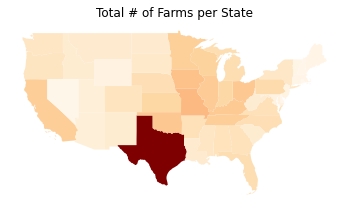

In [18]:
plot_map(num_farms_totals, "State", "Number_of_Farms", title="Total # of Farms per State")

Wow! From this map and the previous table, we can see that Texas has far and away the most farms of any state in the U.S. with over 12% of the nation total.

One question that immediately comes to my mind though, is what this map would look like if we took a look at # of farms ***per capita***. This could really show us which states are "farm states" as opposed to states that just have a large population in general. 

In [19]:
state_pop_df_raw = pd.read_excel("https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx")
rows_to_drop = [0 , 1, 2] + list(range(3,8)) + list(range(59, 66))

new_header_row = state_pop_df_raw.iloc[2].copy()
new_header_row[0] = "State"

state_pop_df = state_pop_df_raw.drop(rows_to_drop)
# state_pop_df.reset_index(inplace=True)
state_pop_df.columns = new_header_row
state_pop_df["State"] = state_pop_df["State"].str.replace(".", "", regex=True)
state_pop_df.reset_index(drop=True, inplace=True)

population_2017 = state_pop_df[["State", 2017]]
population_2017.columns = ["State",  "Population"]
population_2017

,State,Population
0,Alabama,4874486.0
1,Alaska,739700.0
2,Arizona,7044008.0
3,Arkansas,3001345.0
4,California,39358497.0
5,Colorado,5611885.0
6,Connecticut,3573297.0
7,Delaware,956823.0
8,District of Columbia,694906.0
9,Florida,20963613.0


Now we can merge this new population data with our `num_farms_totals` dataframe.

In [20]:
farms_per_capita = num_farms_totals.merge(population_2017, how="left", left_on="State", right_on="State")
farms_per_capita["Farms_per_1000_people"] = farms_per_capita["Number_of_Farms"] / (farms_per_capita["Population"]/1000)
farms_per_capita.sort_values("Farms_per_1000_people", inplace=True, ascending=False)
farms_per_capita.reset_index(drop=True, inplace=True)
farms_per_capita

,State,Number_of_Farms,Percent_US_Total,Population,Farms_per_1000_people
0,North Dakota,26364,1.290948,754942.0,34.921888
1,South Dakota,29968,1.467423,872868.0,34.332797
2,Iowa,86104,4.216196,3141550.0,27.408127
3,Montana,27048,1.324441,1052482.0,25.699252
4,Nebraska,46332,2.268708,1915947.0,24.182297
5,Wyoming,11938,0.584560,578931.0,20.620765
6,Kansas,58569,2.867908,2908718.0,20.135675
7,Oklahoma,78531,3.845374,3931316.0,19.975754
8,Kentucky,75966,3.719776,4452268.0,17.062315
9,Missouri,95320,4.667470,6106670.0,15.609162


In [21]:
# num_farms_totals["Percent_US_Total"] = (num_farms_totals["Number_of_Farms"] / num_farms_totals["Number_of_Farms"].sum()) * 100
print("The 5 U.S. states with the most farms per capita are:\n")
print(farms_per_capita.loc[0:5, ["State", "Farms_per_1000_people"]])

The 5 U.S. states with the most farms per capita are:

          State  Farms_per_1000_people
0  North Dakota              34.921888
1  South Dakota              34.332797
2          Iowa              27.408127
3       Montana              25.699252
4      Nebraska              24.182297
5       Wyoming              20.620765


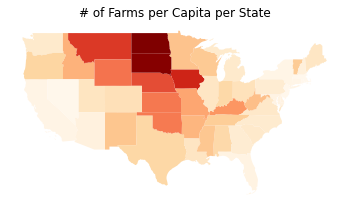

In [22]:
plot_map(farms_per_capita, "State", "Farms_per_1000_people", title="# of Farms per Capita per State")

Looking at the data on a per-capita basis shows a different side of the story. While states like Montana, Wyoming, and the Dakotas don't have an large amount of farms on an absolute level, farm saturation is at higher levels than most other states.

It's worth noting that **Iowa** is 3rd place on the absolute list of number of farms ***and*** 3rd place on the per-capita list. One could make the argument that this makes Iowa the ultimate "farm state".

### Farm size
Next we turn our attention to the geographic size of U.S. farms as measured in acres.

In [23]:
farm_size_text = {
    "AREA OPERATED: (500 TO 999 ACRES)": "500-999",
    "AREA OPERATED: (50 TO 179 ACRES)": "50-179",
    "AREA OPERATED: (180 TO 499 ACRES)": "180-599",
    "AREA OPERATED: (10.0 TO 49.9 ACRES)": "10-49.9",
    "AREA OPERATED: (1.0 TO 9.9 ACRES)": "1-9.9",
    "AREA OPERATED: (1,000 TO 1,999 ACRES)": "1k-1,999",
    "AREA OPERATED: (2,000 OR MORE ACRES)": "2k+",
}

In [24]:
farm_sizes_df = num_farms_df.loc[
    (num_farms_df["agg_level_desc"] == "NATIONAL") & 
    (~num_farms_df["domaincat_desc"].isnull()), 
    ["domaincat_desc", "value", "farm_size_value"]
    ].copy()

farm_sizes_df = farm_sizes_df.sort_values("farm_size_value").reset_index(drop=True)
farm_sizes_df = farm_sizes_df.drop(columns=["farm_size_value"])
farm_sizes_df.columns = ["Farm_Size_Acres", "Number_of_Farms"]
farm_sizes_df["Farm_Size_Acres"] = farm_sizes_df["Farm_Size_Acres"].apply(lambda x: farm_size_text.get(x))
farm_sizes_df

,Farm_Size_Acres,Number_of_Farms
0,1-9.9,273325
1,10-49.9,583001
2,50-179,564763
3,180-599,315017
4,500-999,133321
5,"1k-1,999",87666
6,2k+,85127


Below we can see that most farms are between 10 -179 acres.

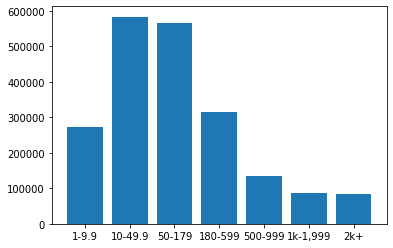

In [25]:
plt.bar(farm_sizes_df["Farm_Size_Acres"], farm_sizes_df["Number_of_Farms"])
plt.show()

Now let's take a look at which states are home to the very large, over 2k acre farms.

In [50]:
large_farms_filter = (
    (num_farms_df["domaincat_desc"] == "AREA OPERATED: (2,000 OR MORE ACRES)") & 
    (num_farms_df["agg_level_desc"] != "NATIONAL")
)

large_farms = num_farms_df.loc[large_farms_filter, ["short_desc", "state_name", "domaincat_desc", "value"]]
print("Number of farms with over 2k acres:")
print(large_farms.groupby(["state_name"])["value"].sum().sort_values(ascending=False)[:10])

Number of farms with over 2k acres:
state_name
Texas           11037
North Dakota     6721
Kansas           6447
Montana          6338
South Dakota     5847
Nebraska         5472
Oklahoma         3637
Colorado         3614
New Mexico       2869
Illinois         2658
Name: value, dtype: int64


### Crops vs. Livestock
Now I'd like to take a look at which states are more livestock focused and which states are more crop focused. The table 1 dataset includes information on total crop sales and total animal salees that we can use to answer this question.

In [51]:
desired_descriptions = ["CROP TOTALS - SALES, MEASURED IN $", "ANIMAL TOTALS, INCL PRODUCTS - SALES, MEASURED IN $"]

crops_livestock_filter = (
        (table_1_df["short_desc"].isin(desired_descriptions)) & 
        (table_1_df["state_name"] != "Us Total")
    )

crops_livestock_df = table_1_df.loc[
    crops_livestock_filter, ["commodity_desc", "state_name", "value"]
    ].copy()

crops_livestock_df = crops_livestock_df.pivot(index="state_name", columns="commodity_desc", values="value")
crops_livestock_df = crops_livestock_df.reset_index()
crops_livestock_df.columns = ["State_Name", "Livestock_Revenue", "Crop_Revenue"]

Below, we classify each state's dominant industry based on whether they have more revenue coming from livestock or crops

In [52]:
crops_livestock_df["Dominant_Industry"] = np.where(
    crops_livestock_df["Livestock_Revenue"] >  crops_livestock_df["Crop_Revenue"], 
    "Livestock", "Crops"
    )

Below we can see that 56.9% of states earn more revenue from livestock than crops.

In [53]:
crops_livestock_df

,State_Name,Livestock_Revenue,Crop_Revenue,Dominant_Industry
0,Alabama,4768266000,1212329000,Livestock
1,Alaska,40817000,29642000,Livestock
2,Arizona,1757790000,2094218000,Crops
3,Arkansas,6026230000,3624930000,Livestock
4,California,11800525000,33353834000,Crops
5,Colorado,5252840000,2238862000,Livestock
6,Connecticut,160071000,420043000,Crops
7,Delaware,1140317000,325656000,Livestock
8,Florida,1652810000,5704533000,Crops
9,Georgia,6301312000,3271940000,Livestock


In [54]:
def print_as_currency(value, postface=""):
    print("${:,}".format(value) + postface)

In [55]:
total_livestock_revenue = crops_livestock_df["Livestock_Revenue"].sum()
total_crop_revenue = crops_livestock_df["Crop_Revenue"].sum()

print_as_currency(total_livestock_revenue, postface=" - US Total Livestock Revenue")
print_as_currency(total_crop_revenue, postface=" - US Total Crop Revenue")

$194,975,996,000 - US Total Livestock Revenue
$193,546,701,000 - US Total Crop Revenue


As can be seen above, U.S. revenue totals for livestock and crops are very similar, with livestock only bringing in about 1.4 billion more in revenue in 2017.

Below we can map out which states earn more revenue for livestock and which earn more from crops

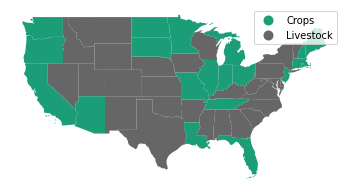

In [56]:
plot_map(crops_livestock_df, "State_Name", "Dominant_Industry", cmap="Dark2", legend=True)

### Focusing in on livestock
Distinguishing between crop farming and livestock farming is helfupl, but livestock is still a very large category that includes:
- Beef cows
- Milk cows
- Hogs
- Chickens

By diving into these details, we can further parse out the dominant type of livestock that each state produces.

We can look at either the total inventory of each animal type by state, or the total number of farms that have inventory of each animal by state. In this case, I'll look at the total number of farms that carry inventory of each animal.


In [57]:
desired_descriptions = [
    "CATTLE, COWS, BEEF - OPERATIONS WITH INVENTORY", 
    "CATTLE, COWS, MILK - OPERATIONS WITH INVENTORY",
    "HOGS - OPERATIONS WITH INVENTORY",
    "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY"
    ]

livestock_details_filter = (
    (table_1_df["short_desc"].isin(desired_descriptions)) &
    (table_1_df["state_name"] != "Us Total")
    )

livestock_details_df_raw = table_1_df.loc[
    livestock_details_filter,
    ["short_desc", "state_name", "value"]
    ]
    
livestock_details_df_raw

,short_desc,state_name,value
2298,"CATTLE, COWS, BEEF - OPERATIONS WITH INVENTORY",Alabama,20004
2299,"CATTLE, COWS, BEEF - OPERATIONS WITH INVENTORY",Alaska,92
2300,"CATTLE, COWS, BEEF - OPERATIONS WITH INVENTORY",Arizona,5560
2301,"CATTLE, COWS, BEEF - OPERATIONS WITH INVENTORY",Arkansas,23036
2302,"CATTLE, COWS, BEEF - OPERATIONS WITH INVENTORY",California,10254
...,...,...,...
2853,"CHICKENS, LAYERS - OPERATIONS WITH INVENTORY",Virginia,5729
2854,"CHICKENS, LAYERS - OPERATIONS WITH INVENTORY",Washington,6451
2855,"CHICKENS, LAYERS - OPERATIONS WITH INVENTORY",West Virginia,4464
2856,"CHICKENS, LAYERS - OPERATIONS WITH INVENTORY",Wisconsin,7992


In [58]:
livestock_details_df = livestock_details_df_raw.pivot(index="state_name", columns="short_desc", values="value")
percentages = livestock_details_df.div(livestock_details_df.sum(axis=1), axis=0)

percentage_columns = ["Percent_Beef_Cow_Farms", "Percent_Milk_Cow_Farms", "Percent_Chicken_Farms", "Percent_Hog_Farms"]
percentages.columns = percentage_columns

livestock_details_df = livestock_details_df.join(percentages)
livestock_details_df = livestock_details_df.reset_index()
livestock_details_df.columns = [
    "State_Name", "Num_Beef_Cow_Farms", "Num_Milk_Cow_Farms", 
    "Num_Chicken_Farms", "Num_Hog_Farms"] + percentage_columns

for column in percentage_columns:
    livestock_details_df[column] = livestock_details_df[column].round(2)

livestock_details_df

,State_Name,Num_Beef_Cow_Farms,Num_Milk_Cow_Farms,Num_Chicken_Farms,Num_Hog_Farms,Percent_Beef_Cow_Farms,Percent_Milk_Cow_Farms,Percent_Chicken_Farms,Percent_Hog_Farms
0,Alabama,20004,366,3793,1074,0.79,0.01,0.15,0.04
1,Alaska,92,27,189,64,0.25,0.07,0.51,0.17
2,Arizona,5560,186,2345,521,0.65,0.02,0.27,0.06
3,Arkansas,23036,72,4249,1021,0.81,0.00,0.15,0.04
4,California,10254,1653,6546,1389,0.52,0.08,0.33,0.07
5,Colorado,12407,583,5919,1227,0.62,0.03,0.29,0.06
6,Connecticut,860,198,1265,214,0.34,0.08,0.50,0.08
7,Delaware,235,50,200,55,0.44,0.09,0.37,0.10
8,Florida,18493,600,6339,1810,0.68,0.02,0.23,0.07
9,Georgia,14869,572,4743,1091,0.70,0.03,0.22,0.05


As we can see from the table above, for most states, the majority of their live stock farms are focused on beef.

Below we can take a look at all states where beef cattle farms do not form the majority. Unsurprisingly, these states are primarily smaller, north-eastern states that don't have much land area for beef cattle.

In [59]:
non_beef_majority_filter = livestock_details_df["Percent_Beef_Cow_Farms"] <= 0.5

livestock_details_df.loc[non_beef_majority_filter]

,State_Name,Num_Beef_Cow_Farms,Num_Milk_Cow_Farms,Num_Chicken_Farms,Num_Hog_Farms,Percent_Beef_Cow_Farms,Percent_Milk_Cow_Farms,Percent_Chicken_Farms,Percent_Hog_Farms
1,Alaska,92,27,189,64,0.25,0.07,0.51,0.17
6,Connecticut,860,198,1265,214,0.34,0.08,0.50,0.08
7,Delaware,235,50,200,55,0.44,0.09,0.37,0.10
18,Maine,1141,450,1892,429,0.29,0.12,0.48,0.11
19,Maryland,2486,511,2009,562,0.45,0.09,0.36,0.10
20,Massachusetts,879,220,1713,337,0.28,0.07,0.54,0.11
21,Michigan,7445,2158,7039,2017,0.40,0.12,0.38,0.11
28,New Hampshire,602,216,1145,281,0.27,0.10,0.51,0.13
29,New Jersey,941,109,1986,347,0.28,0.03,0.59,0.10
31,New York,7310,4648,5712,1739,0.38,0.24,0.29,0.09


Below we take a loook at 5 states with the most total farms and highest percentage of farms for each livestock type.

In [60]:
livestock_types = ["Beef_Cow", "Milk_Cow", "Chicken", "Hog"]
top_5_states = {}

def print_top_five_states(column_prefix, print_postface):
    for livestock_type in livestock_types:
        column_name = column_prefix + "_" + livestock_type + "_Farms"
        states = livestock_details_df[
        ["State_Name", column_name]
        ].sort_values(column_name, ascending=False).iloc[:5].reset_index(drop=True)

        top_5_states[livestock_type] = states["State_Name"]

        print("Top 5 " + livestock_type + " states " + print_postface)
        print(states)
        print("\n")

print_top_five_states("Num", "(Total # of Farms)")
print("---------------\n")
print_top_five_states("Percent", "(Percentage of Farms)")

Top 5 Beef_Cow states (Total # of Farms)
  State_Name  Num_Beef_Cow_Farms
0      Texas              134250
1   Missouri               48122
2   Oklahoma               46080
3   Kentucky               33864
4  Tennessee               32960


Top 5 Milk_Cow states (Total # of Farms)
     State_Name  Num_Milk_Cow_Farms
0     Wisconsin                9037
1  Pennsylvania                6914
2      New York                4648
3     Minnesota                3644
4          Ohio                3346


Top 5 Chicken states (Total # of Farms)
     State_Name  Num_Chicken_Farms
0         Texas              28096
1          Ohio              10274
2      Oklahoma               9894
3  Pennsylvania               9290
4      Missouri               9052


Top 5 Hog states (Total # of Farms)
     State_Name  Num_Hog_Farms
0         Texas           5894
1          Iowa           5660
2          Ohio           3484
3     Minnesota           3225
4  Pennsylvania           2777


---------------

Top 5 B

Now let's map out the locations of the top 5 states (percentage wise) for each livestock category.

In [69]:
livestock_details_df["top_five_beef_cow"] = livestock_details_df["State_Name"].isin(top_5_states["Beef_Cow"])

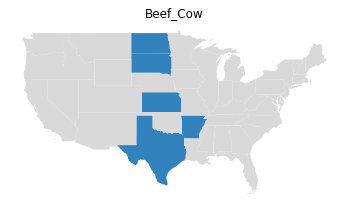

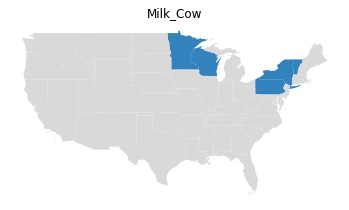

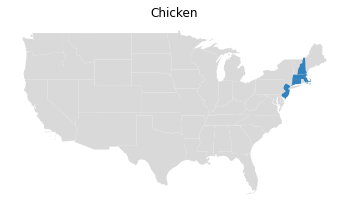

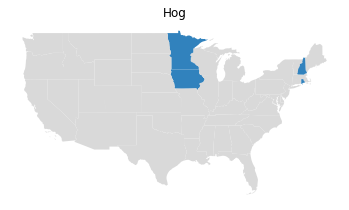

In [74]:
# TODO: add map title and different cmaps for each one. Remove ticks
for livestock_type in livestock_types:
    column_name = "top_five_" + livestock_type
    livestock_details_df[column_name] = ~livestock_details_df["State_Name"].isin(top_5_states[livestock_type])
    plot_map(livestock_details_df, "State_Name", column_name, title=livestock_type, cmap="tab20c")

### Farmer Gender

In [ ]:
farmer_gender_df

### Farmer Race

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=05802224-8515-4af2-8e4b-abb5e40d0066' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>